In [ ]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os

from image_utils import *
from template_matching import *

# Run Validation

The shape of the image is (100, 672, 672)


Text(0.5, 1.0, 'Applied segmentation mask')

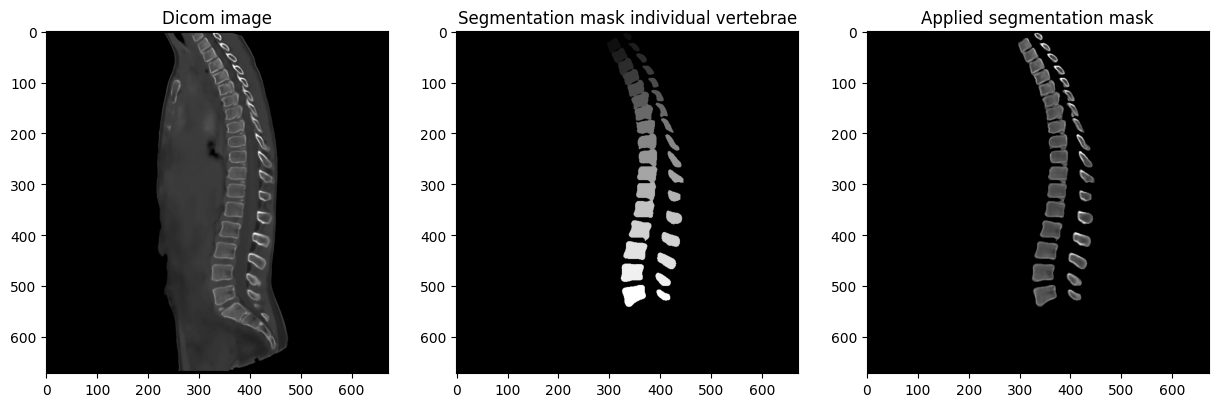

In [ ]:
# Image paths
dicom_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS24")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS24_Segmentation.nii")

# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask")

In [59]:
# Get the vertebrae labels and their corresponding euler angles
_, _, euler_angles = get_euler_angles(segment_data)
vertebrae_labels = np.unique(segment_data)[1:]

Computed bounding box for 17 vertebra


In [ ]:
# Angle bounds for sagittal, coronal, and axial rotations
bounds = [(-35, 35), (0, 0), (-10, 10)]

optimized_angles = {}
random_angles= {}

for label in vertebrae_labels:
    template = generate_template(segment_dicom_image, segment_data, label, euler_angles)

    # Skip if template is empty
    if template.shape[0] == 0 or template.shape[1] == 0:
        print(f"Skipping label {label} as the template is empty")
        continue

    optimized_angles[label] = []
    random_angles[label] = []

    i = 0
    while i < n:
        # Sample random angles
        saggital_angle = np.random.uniform(bounds[0][0], bounds[0][1])
        axial_angle = np.random.uniform(bounds[2][0], bounds[2][1])
        bounds_temp = [(-45 - saggital_angle, 45 - saggital_angle), (0, 0), (-15 - axial_angle, 15 - axial_angle)]
        
        try:
            ROI_3D_image, ref_3D_image, rotated_image, rotated_mask = make_input_3D_ROI(
                segment_dicom_image, segment_data, label, euler_angles,
                saggital_angle=saggital_angle, coronal_angle=0, axial_angle=axial_angle
            )

            optimal_angles = optimize_rotation(ROI_3D_image, template, bounds_temp)

            random_angles[label].append([saggital_angle, 0, axial_angle])
            optimized_angles[label].append(optimal_angles)

            print(f"Best Angles for label {label}: Saggital={optimal_angles[0]} degrees, Coronal={optimal_angles[1]} degrees, Axial={optimal_angles[2]} degrees")

            i += 1  # increment only when successful

        except Exception as e:
            print(f"Trial {i+1} failed: {e}")
            # will retry with another random angle

The updated euler angles after initial rotation are:  [22.3447283 -2.5985868 -5.7127201]
Best Angles for label 1: Saggital=23.64959480158747 degrees, Coronal=0.0 degrees, Axial=-5.6387686195715085 degrees
The updated euler angles after initial rotation are:  [ -6.99123516  -2.5985868  -20.95841006]
Best Angles for label 1: Saggital=-4.004384594354967 degrees, Coronal=0.0 degrees, Axial=-20.48258404046186 degrees
The updated euler angles after initial rotation are:  [ -7.10149739  -2.5985868  -16.30975628]
Best Angles for label 1: Saggital=-6.27297161911531 degrees, Coronal=0.0 degrees, Axial=-15.924763204496255 degrees
The updated euler angles after initial rotation are:  [ 40.91514341  -2.5985868  -21.82213276]
Trial 4 failed: zero-size array to reduction operation minimum which has no identity
The updated euler angles after initial rotation are:  [ 26.05510558  -2.5985868  -21.66556995]
Best Angles for label 1: Saggital=26.486782126425616 degrees, Coronal=0.0 degrees, Axial=-19.12665

In [64]:
import json
import os

def to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

output_dir = "result"
n_image = 'EBS24'
os.makedirs(output_dir, exist_ok=True)

optimized_angles_str_keys = {str(k): [to_serializable(x) for x in v] for k, v in optimized_angles.items()}
random_angles_str_keys = {str(k): [to_serializable(x) for x in v] for k, v in random_angles.items()}

with open(f"{output_dir}/{n_image}_optimized_angles.json", 'w') as f:
    json.dump(optimized_angles_str_keys, f, indent=4)

with open(f"{output_dir}/{n_image}_random_angles.json", 'w') as f:
    json.dump(random_angles_str_keys, f, indent=4)

In [65]:
import os

# Helper function to make data JSON-serializable
def to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

output_dir = "result"

# Create result folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Convert keys to string and values to serializable formats
optimized_angles_str_keys = {str(k): [to_serializable(x) for x in v] for k, v in optimized_angles.items()}
random_angles_str_keys = {str(k): [to_serializable(x) for x in v] for k, v in random_angles.items()}

# Save optimized angles
with open(f"{output_dir}/{n_image}_optimized_angles.json", 'w') as f:
    json.dump(optimized_angles_str_keys, f, indent=4)

# Save random angles
with open(f"{output_dir}/{n_image}_random_angles.json", 'w') as f:
    json.dump(random_angles_str_keys, f, indent=4)


Sagittal - ME: 6.638, MAE: 8.470, R: 0.965
Axial - ME: -0.094, MAE: 0.997, R: 0.921


# Run Analysis

## Load all the data

In [7]:
import os
import glob
import SimpleITK as sitk

def load_boneMRI_images(root_dir, n_range=range(23, 28)):
    dicom_images = []
    segmentations = []
    segment_dicom_images = []
    euler_angles_list = []

    for n in sorted(n_range):
        # Match folder and segmentation file ignoring date
        dicom_path_pattern = os.path.join(root_dir, f"2024*BoneMRI_EBS{n}")
        segmentation_path_pattern = os.path.join(root_dir, f"2024*BoneMRI_EBS{n}_Segmentation.nii")

        dicom_path = glob.glob(dicom_path_pattern)
        segmentation_path = glob.glob(segmentation_path_pattern)

        if not dicom_path or not segmentation_path:
            print(f"Warning: Missing data for EBS{n}")
            continue

        dicom_path = dicom_path[0]
        segmentation_path = segmentation_path[0]

        # Load segmentation
        segment = sitk.ReadImage(segmentation_path)
        segment_data = sitk.GetArrayFromImage(segment)
        segment_all = segment_data > 0

        # Load dicom and apply windowing
        dicom_image = load_3d_dicom(dicom_path)
        dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
        segment_dicom_image = dicom_image * segment_all

        # Get euler angles
        _, _, euler_angles = get_euler_angles(segment_data)

        # Store into lists
        dicom_images.append(dicom_image)
        segmentations.append(segment_data)
        segment_dicom_images.append(segment_dicom_image)
        euler_angles_list.append(euler_angles)

        print(f"Loaded EBS{n} | Shape: {dicom_image.shape}")

    return dicom_images, segmentations, segment_dicom_images, euler_angles_list

root_dir = "boneMRI"
dicom_images, segmentations, segment_dicom_images, euler_angles_list = load_boneMRI_images(root_dir, n_range=range(23, 28))

Loaded EBS23 | Shape: (100, 672, 672)
Loaded EBS24 | Shape: (100, 672, 672)
Loaded EBS25 | Shape: (100, 672, 672)
Loaded EBS26 | Shape: (100, 672, 672)
Loaded EBS27 | Shape: (100, 672, 672)


In [2]:
import os
import json
import numpy as np

def load_all_angle_jsons(output_dir="result", n_range=range(23, 28)):
    optimized_angles_list = []
    random_angles_list = []

    for n in sorted(n_range):
        n_image = f"EBS{n}"

        # Load JSON files
        optimized_path = os.path.join(output_dir, f"{n_image}_optimized_angles.json")
        random_path = os.path.join(output_dir, f"{n_image}_random_angles.json")

        if not (os.path.exists(optimized_path) and os.path.exists(random_path)):
            print(f"Warning: Missing JSONs for {n_image}")
            continue

        with open(optimized_path, 'r') as f:
            optimized_angles_str_keys = json.load(f)

        with open(random_path, 'r') as f:
            random_angles_str_keys = json.load(f)

        # Convert keys back to int and values back to numpy arrays
        optimized_angles = {int(k): [np.array(x) for x in v] for k, v in optimized_angles_str_keys.items()}
        random_angles = {int(k): [np.array(x) for x in v] for k, v in random_angles_str_keys.items()}

        optimized_angles_list.append(optimized_angles)
        random_angles_list.append(random_angles)

        print(f"Loaded angles for {n_image}")

    return optimized_angles_list, random_angles_list

optimized_angles_list, random_angles_list = load_all_angle_jsons()

Loaded angles for EBS23
Loaded angles for EBS24
Loaded angles for EBS25
Loaded angles for EBS26
Loaded angles for EBS27


## ME, MAE

In [ ]:
from scipy.stats import pearsonr
print("=== Per-Vertebra Metrics Across All Cases ===")

for label in range(1, 18):  # vertebrae 1 to 17
    sag_gt_all = []
    sag_pred_all = []
    
    ax_gt_all = []
    ax_pred_all = []

    for case_idx in range(len(optimized_angles_list)):
        optimized_dict = optimized_angles_list[case_idx]
        random_dict = random_angles_list[case_idx]

        # Subtract values for each key
        angle_diff = {
            label: np.array(optimized_dict[label]) + np.array(random_dict[label])
            for label in optimized_dict
            if label in random_dict
        }
        euler_angles = euler_angles_list[case_idx]

        if label not in angle_diff:
            continue  # skip if the vertebra is missing

        preds = np.array(angle_diff[label])

        # Collect sagittal
        sag_gt = euler_angles[label][0]
        sag_preds = preds[:, 0]
        sag_gt_all.extend([sag_gt] * len(sag_preds))
        sag_pred_all.extend(sag_preds.tolist())

        # Collect axial
        ax_gt = euler_angles[label][2]
        ax_preds = preds[:, 2]
        ax_gt_all.extend([ax_gt] * len(ax_preds))
        ax_pred_all.extend(ax_preds.tolist())

    if len(sag_gt_all) == 0:
        print(f"Label {label}: No data found.")
        continue

    # Compute sagittal metrics
    sag_gt_all = np.array(sag_gt_all)
    sag_pred_all = np.array(sag_pred_all)
    sag_me = np.mean(sag_pred_all - sag_gt_all)
    sag_mae = np.mean(np.abs(sag_pred_all - sag_gt_all))
    sag_r, _ = pearsonr(sag_gt_all, sag_pred_all)

    # Compute axial metrics
    ax_gt_all = np.array(ax_gt_all)
    ax_pred_all = np.array(ax_pred_all)
    ax_me = np.mean(ax_pred_all - ax_gt_all)
    ax_mae = np.mean(np.abs(ax_pred_all - ax_gt_all))
    ax_r, _ = pearsonr(ax_gt_all, ax_pred_all)

    # Print
    print(f"Vertebra {label:02d} | Sagittal -> ME: {sag_me:.2f}, MAE: {sag_mae:.2f} | Axial -> ME: {ax_me:.2f}, MAE: {ax_mae:.2f}")

=== Per-Vertebra Metrics Across All Cases ===
Vertebra 01 | Sagittal -> ME: 1.75, MAE: 3.77 | Axial -> ME: 0.56, MAE: 1.38
Vertebra 02 | Sagittal -> ME: 1.29, MAE: 2.53 | Axial -> ME: 0.27, MAE: 1.18
Vertebra 03 | Sagittal -> ME: 5.28, MAE: 6.67 | Axial -> ME: 0.33, MAE: 1.83
Vertebra 04 | Sagittal -> ME: 9.88, MAE: 10.14 | Axial -> ME: 0.30, MAE: 1.46
Vertebra 05 | Sagittal -> ME: 16.93, MAE: 17.09 | Axial -> ME: -0.39, MAE: 1.41
Vertebra 06 | Sagittal -> ME: 12.92, MAE: 13.14 | Axial -> ME: -0.40, MAE: 1.14
Vertebra 07 | Sagittal -> ME: 14.42, MAE: 14.69 | Axial -> ME: -0.01, MAE: 0.97
Vertebra 08 | Sagittal -> ME: 14.86, MAE: 15.19 | Axial -> ME: 0.06, MAE: 1.31
Vertebra 09 | Sagittal -> ME: 9.33, MAE: 9.61 | Axial -> ME: -0.28, MAE: 0.83
Vertebra 10 | Sagittal -> ME: -0.06, MAE: 0.44 | Axial -> ME: 0.04, MAE: 0.54
Vertebra 11 | Sagittal -> ME: -0.10, MAE: 0.32 | Axial -> ME: 0.00, MAE: 0.52
Vertebra 12 | Sagittal -> ME: -0.15, MAE: 0.46 | Axial -> ME: -0.05, MAE: 0.40
Vertebra 13 |

## Plot Combined

In [53]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === CONFIG ===
vertebrae_map = {i: f"T{i}" for i in range(1, 13)}
vertebrae_map.update({i: f"L{i - 12}" for i in range(13, 18)})
thoracic_labels = list(range(1, 13))
lumbar_labels = list(range(13, 18))

# === DATA STRUCTURES ===
sag_gt_dict = defaultdict(list)
sag_all_preds_dict = defaultdict(list)

ax_gt_dict = defaultdict(list)
ax_all_preds_dict = defaultdict(list)

# === COLLECT DATA ===
for label in range(1, 18):
    sag_preds = []
    sag_gt = []
    ax_preds = []
    ax_gt = []
    for case_idx in range(len(optimized_angles_list)):
        optimized_dict = optimized_angles_list[case_idx]
        random_dict = random_angles_list[case_idx]
        angle_diff = {
            label: np.array(optimized_dict[label]) + np.array(random_dict[label])
            for label in optimized_dict
            if label in random_dict
        }
        euler_angles = euler_angles_list[case_idx]
        sag_preds.extend(angle_diff[label][:, 0])
        sag_gt.extend([euler_angles[label][0]] * len(angle_diff[label][:, 0]))
        ax_preds.extend(angle_diff[label][:, 2])
        ax_gt.extend([euler_angles[label][2]] * len(angle_diff[label][:, 2]))
    sag_all_preds_dict[label] = sag_preds
    sag_gt_dict[label] = sag_gt
    ax_all_preds_dict[label] = ax_preds
    ax_gt_dict[label] = ax_gt

# === SCATTER PLOTS ===
plt.figure(figsize=(12, 5))
sag_gt_all, sag_pred_all = [], []
ax_gt_all, ax_pred_all = [], []

# --- Sagittal ---
plt.subplot(1, 2, 1)
for label in sorted(sag_gt_dict.keys()):
    mean_gt = np.mean(sag_gt_dict[label])
    all_preds = np.array(sag_all_preds_dict[label])
    mean_pred = np.mean(all_preds)
    std_pred = np.std(all_preds)

    sag_gt_all.append(mean_gt)
    sag_pred_all.append(mean_pred)

    color = 'blue' if label in thoracic_labels else 'orange'
    plt.errorbar(mean_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
    plt.text(mean_gt, mean_pred, vertebrae_map[label], fontsize=8)

plt.plot([-45, 45], [-45, 45], 'k--')
plt.xlim([-45, 45])
plt.ylim([-45, 45])
sag_gt_all = np.array(sag_gt_all)
sag_pred_all = np.array(sag_pred_all)
sag_me = np.mean(sag_pred_all - sag_gt_all)
sag_mae = np.mean(np.abs(sag_pred_all - sag_gt_all))
sag_r, _ = pearsonr(sag_gt_all, sag_pred_all)
plt.title(f'Sagittal Correlation\nME={sag_me:.2f}, MAE={sag_mae:.2f}, R={sag_r:.2f}')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

# --- Axial ---
plt.subplot(1, 2, 2)
for label in sorted(ax_gt_dict.keys()):
    mean_gt = np.mean(ax_gt_dict[label])
    all_preds = np.array(ax_all_preds_dict[label])
    mean_pred = np.mean(all_preds)
    std_pred = np.std(all_preds)

    ax_gt_all.append(mean_gt)
    ax_pred_all.append(mean_pred)

    color = 'blue' if label in thoracic_labels else 'orange'
    plt.errorbar(mean_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
    plt.text(mean_gt, mean_pred, vertebrae_map[label], fontsize=8)

plt.plot([-10, 10], [-10, 10], 'k--')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax_gt_all = np.array(ax_gt_all)
ax_pred_all = np.array(ax_pred_all)
ax_me = np.mean(ax_pred_all - ax_gt_all)
ax_mae = np.mean(np.abs(ax_pred_all - ax_gt_all))
ax_r, _ = pearsonr(ax_gt_all, ax_pred_all)
plt.title(f'Axial Correlation\nME={ax_me:.2f}, MAE={ax_mae:.2f}, R={ax_r:.2f}')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')
plt.grid(True)

plt.tight_layout()
plt.savefig("result/all_combined_avg_scatter.png")
plt.close()

# === BLAND-ALTMAN PLOTS ===
plt.figure(figsize=(12, 5))

# --- Sagittal ---
plt.subplot(1, 2, 1)
avg_sag, diff_sag = [], []
for label in sorted(sag_gt_dict.keys()):
    mean_gt = np.mean(sag_gt_dict[label])
    mean_pred = np.mean(sag_all_preds_dict[label])
    color = 'blue' if label in thoracic_labels else 'orange'

    avg = (mean_gt + mean_pred) / 2
    diff = mean_pred - mean_gt

    avg_sag.append(avg)
    diff_sag.append(diff)

    plt.scatter(avg, diff, color=color)
    plt.text(avg, diff, vertebrae_map[label], fontsize=8)

mean_diff_sag = np.mean(diff_sag)
std_diff_sag = np.std(diff_sag)
plt.axhline(mean_diff_sag, color='red', linestyle='--', label=f'Mean={mean_diff_sag:.2f}')
plt.axhline(mean_diff_sag + 1.96 * std_diff_sag, color='gray', linestyle='--')
plt.axhline(mean_diff_sag - 1.96 * std_diff_sag, color='gray', linestyle='--')
plt.title("Bland-Altman (Sagittal)")
plt.xlabel('Average (GT + Pred) / 2')
plt.ylabel('Difference (Pred - GT)')
plt.grid(True)
plt.legend()

# --- Axial ---
plt.subplot(1, 2, 2)
avg_ax, diff_ax = [], []
for label in sorted(ax_gt_dict.keys()):
    mean_gt = np.mean(ax_gt_dict[label])
    mean_pred = np.mean(ax_all_preds_dict[label])
    color = 'blue' if label in thoracic_labels else 'orange'

    avg = (mean_gt + mean_pred) / 2
    diff = mean_pred - mean_gt

    avg_ax.append(avg)
    diff_ax.append(diff)

    plt.scatter(avg, diff, color=color)
    plt.text(avg, diff, vertebrae_map[label], fontsize=8)

mean_diff_ax = np.mean(diff_ax)
std_diff_ax = np.std(diff_ax)
plt.axhline(mean_diff_ax, color='red', linestyle='--', label=f'Mean={mean_diff_ax:.2f}')
plt.axhline(mean_diff_ax + 1.96 * std_diff_ax, color='gray', linestyle='--')
plt.axhline(mean_diff_ax - 1.96 * std_diff_ax, color='gray', linestyle='--')
plt.title("Bland-Altman (Axial)")
plt.xlabel('Average (GT + Pred) / 2')
plt.ylabel('Difference (Pred - GT)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("result/all_combined_avg_bland_altman.png")
plt.close()

# === METRICS ===
print(f"Sagittal - ME: {sag_me:.3f}, MAE: {sag_mae:.3f}, R: {sag_r:.3f}")
print(f"Axial   - ME: {ax_me:.3f}, MAE: {ax_mae:.3f}, R: {ax_r:.3f}")


Sagittal - ME: 5.059, MAE: 5.139, R: 0.969
Axial   - ME: 0.020, MAE: 0.191, R: 0.990


## Plot per images

In [55]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === CONFIG ===
vertebrae_map = {i: f"T{i}" for i in range(1, 13)}
vertebrae_map.update({i: f"L{i - 12}" for i in range(13, 18)})
thoracic_labels = list(range(1, 13))
lumbar_labels = list(range(13, 18))
image_ids = [f"EBS{n}" for n in range(23, 28)]

# === LOOP THROUGH EACH IMAGE ===
for i, image_id in enumerate(image_ids):
    sag_gt_dict = defaultdict(list)
    sag_all_preds_dict = defaultdict(list)
    ax_gt_dict = defaultdict(list)
    ax_all_preds_dict = defaultdict(list)

    optimized_dict = optimized_angles_list[i]
    random_dict = random_angles_list[i]
    euler_angles = euler_angles_list[i]

    for label in optimized_dict:
        if label not in random_dict or label not in euler_angles:
            continue

        preds = np.array(optimized_dict[label]) + np.array(random_dict[label])
        gt = euler_angles[label]

        sag_all_preds_dict[label].extend(preds[:, 0])
        sag_gt_dict[label].extend([gt[0]] * preds.shape[0])
        ax_all_preds_dict[label].extend(preds[:, 2])
        ax_gt_dict[label].extend([gt[2]] * preds.shape[0])

    # === CORRELATION PLOT ===
    plt.figure(figsize=(12, 5))
    sag_gt_all, sag_pred_all = [], []
    ax_gt_all, ax_pred_all = [], []

    # --- Sagittal ---
    plt.subplot(1, 2, 1)
    for label in sorted(sag_gt_dict.keys()):
        mean_gt = np.mean(sag_gt_dict[label])
        preds = np.array(sag_all_preds_dict[label])
        mean_pred = np.mean(preds)
        std_pred = np.std(preds)

        sag_gt_all.append(mean_gt)
        sag_pred_all.append(mean_pred)

        color = 'blue' if label in thoracic_labels else 'orange'
        plt.errorbar(mean_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
        plt.text(mean_gt, mean_pred, vertebrae_map[label], fontsize=8)

    plt.plot([-45, 45], [-45, 45], 'k--')
    plt.xlim([-45, 45])
    plt.ylim([-45, 45])
    sag_gt_all = np.array(sag_gt_all)
    sag_pred_all = np.array(sag_pred_all)
    sag_me = np.mean(sag_pred_all - sag_gt_all)
    sag_mae = np.mean(np.abs(sag_pred_all - sag_gt_all))
    sag_r, _ = pearsonr(sag_gt_all, sag_pred_all)
    plt.title(f'{image_id} Sagittal\nME={sag_me:.2f}, MAE={sag_mae:.2f}, R={sag_r:.2f}')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True)

    # --- Axial ---
    plt.subplot(1, 2, 2)
    for label in sorted(ax_gt_dict.keys()):
        mean_gt = np.mean(ax_gt_dict[label])
        preds = np.array(ax_all_preds_dict[label])
        mean_pred = np.mean(preds)
        std_pred = np.std(preds)

        ax_gt_all.append(mean_gt)
        ax_pred_all.append(mean_pred)

        color = 'blue' if label in thoracic_labels else 'orange'
        plt.errorbar(mean_gt, mean_pred, yerr=std_pred, fmt='o', color=color)
        plt.text(mean_gt, mean_pred, vertebrae_map[label], fontsize=8)

    plt.plot([-10, 10], [-10, 10], 'k--')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    ax_gt_all = np.array(ax_gt_all)
    ax_pred_all = np.array(ax_pred_all)
    ax_me = np.mean(ax_pred_all - ax_gt_all)
    ax_mae = np.mean(np.abs(ax_pred_all - ax_gt_all))
    ax_r, _ = pearsonr(ax_gt_all, ax_pred_all)
    plt.title(f'{image_id} Axial\nME={ax_me:.2f}, MAE={ax_mae:.2f}, R={ax_r:.2f}')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"result/{image_id}_scatter.png")
    plt.close()

    # === BLAND-ALTMAN PLOT ===
    plt.figure(figsize=(12, 5))

    # --- Sagittal ---
    plt.subplot(1, 2, 1)
    avg_sag, diff_sag = [], []
    for label in sorted(sag_gt_dict.keys()):
        mean_gt = np.mean(sag_gt_dict[label])
        mean_pred = np.mean(sag_all_preds_dict[label])
        color = 'blue' if label in thoracic_labels else 'orange'

        avg = (mean_gt + mean_pred) / 2
        diff = mean_pred - mean_gt

        avg_sag.append(avg)
        diff_sag.append(diff)

        plt.scatter(avg, diff, color=color)
        plt.text(avg, diff, vertebrae_map[label], fontsize=8)

    mean_diff = np.mean(diff_sag)
    std_diff = np.std(diff_sag)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean={mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f'{image_id} Bland-Altman (Sagittal)')
    plt.xlabel('Average (GT + Pred) / 2')
    plt.ylabel('Difference (Pred - GT)')
    plt.grid(True)
    plt.legend()

    # --- Axial ---
    plt.subplot(1, 2, 2)
    avg_ax, diff_ax = [], []
    for label in sorted(ax_gt_dict.keys()):
        mean_gt = np.mean(ax_gt_dict[label])
        mean_pred = np.mean(ax_all_preds_dict[label])
        color = 'blue' if label in thoracic_labels else 'orange'

        avg = (mean_gt + mean_pred) / 2
        diff = mean_pred - mean_gt

        avg_ax.append(avg)
        diff_ax.append(diff)

        plt.scatter(avg, diff, color=color)
        plt.text(avg, diff, vertebrae_map[label], fontsize=8)

    mean_diff = np.mean(diff_ax)
    std_diff = np.std(diff_ax)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean={mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f'{image_id} Bland-Altman (Axial)')
    plt.xlabel('Average (GT + Pred) / 2')
    plt.ylabel('Difference (Pred - GT)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"result/{image_id}_bland_altman.png")
    plt.close()
